In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'1.10.0'

## 1.Data (prepaing and Loading)

In [2]:
# create 'known' parameters
weight = 0.6
bias = 0.2

# create data 
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2000],
         [0.2120],
         [0.2240],
         [0.2360],
         [0.2480],
         [0.2600],
         [0.2720],
         [0.2840],
         [0.2960],
         [0.3080]]))

### Split data into training and test sets 

In [3]:
# create train/test split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data = X_train, 
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

    plt.scatter(test_data, test_labels, c = 'g', s = 4, label = 'Test data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='predictions')

    plt.legend(prop={'size':14})    
    

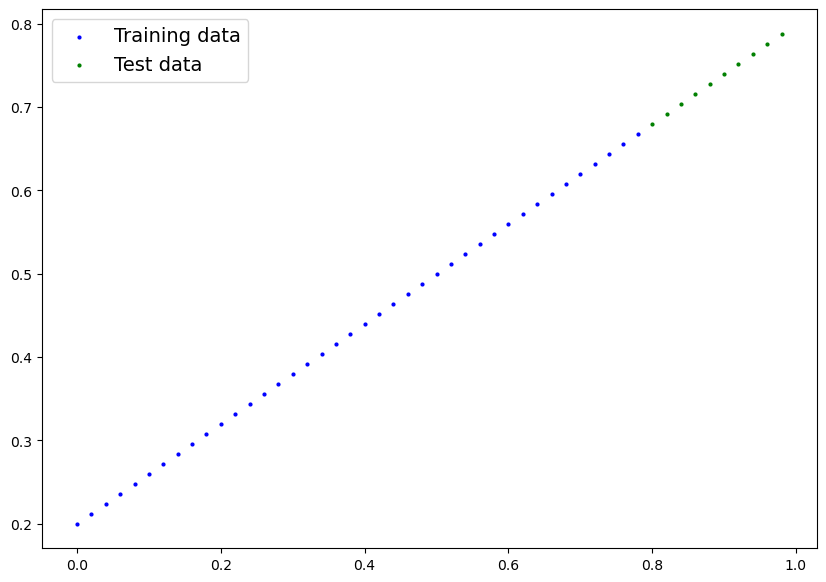

In [5]:
plot_predictions();

## 2. Build model


In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True)
        
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad = True)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### Checking the contents of PyTorch model

In [16]:

torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())
 

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [17]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()` 

In [18]:
with torch.inference_mode():
    y_preds = model_0(X_test)

In [19]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


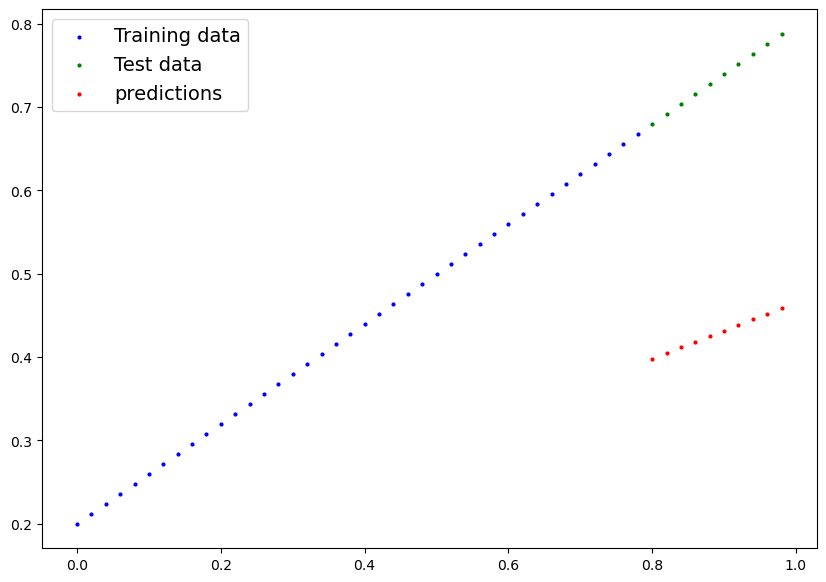

In [20]:
plot_predictions(predictions=y_preds)

## 3. Train model

### Creating a loss function and optimizer in PyTorch

In [21]:
# Create the loss function
loss_fn = nn.L1Loss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)


### Creating an optimization loop in PyTorch

In [22]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1.  Forward pass on train data using the forward method inside
    y_pred = model_0(X_train)

    # 2. calculate the loss (how diff are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ## Testing
    model_0.eval() # Turns off settings that isn't required for Evaluation/Testing (ex: dropout)

    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_0(X_test)

        # 2. calculate the loss
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

    # print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | MAE Train loss: {loss} | MAE Test loss: {test_loss}")

Epoch: 0 | MAE Train loss: 0.17388135194778442 | MAE Test loss: 0.29206520318984985
Epoch: 10 | MAE Train loss: 0.06607577949762344 | MAE Test loss: 0.16355101764202118
Epoch: 20 | MAE Train loss: 0.039144229143857956 | MAE Test loss: 0.10241486877202988
Epoch: 30 | MAE Train loss: 0.03429242596030235 | MAE Test loss: 0.08263428509235382
Epoch: 40 | MAE Train loss: 0.030802428722381592 | MAE Test loss: 0.07161422073841095
Epoch: 50 | MAE Train loss: 0.02735968492925167 | MAE Test loss: 0.0633416697382927
Epoch: 60 | MAE Train loss: 0.0239248163998127 | MAE Test loss: 0.05506915599107742
Epoch: 70 | MAE Train loss: 0.02048618160188198 | MAE Test loss: 0.047483570873737335
Epoch: 80 | MAE Train loss: 0.017057739198207855 | MAE Test loss: 0.039211105555295944
Epoch: 90 | MAE Train loss: 0.013621193356812 | MAE Test loss: 0.03093862533569336


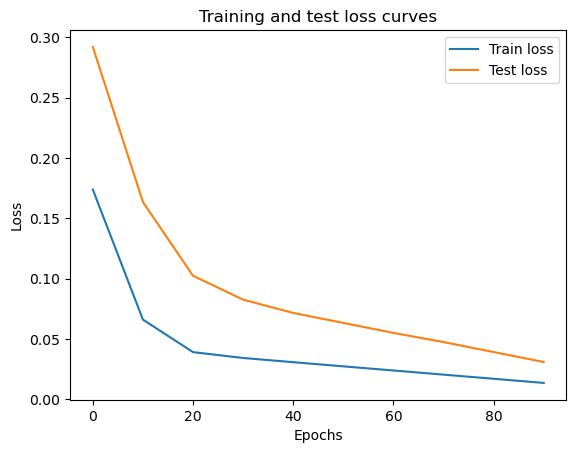

In [24]:
# plot the loss curves
plt.plot(epoch_count, train_loss_values, label='Train loss')
plt.plot(epoch_count, test_loss_values, label = 'Test loss')
plt.title("Training and test loss curves")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend();

In [25]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5494])), ('bias', tensor([0.2213]))])

And the original values for weights and bias are:
weights: 0.6, bias: 0.2


## 4. Making predictions with a trained PyTorch model (inference)

In [26]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.6608],
        [0.6718],
        [0.6828],
        [0.6938],
        [0.7047],
        [0.7157],
        [0.7267],
        [0.7377],
        [0.7487],
        [0.7597]])

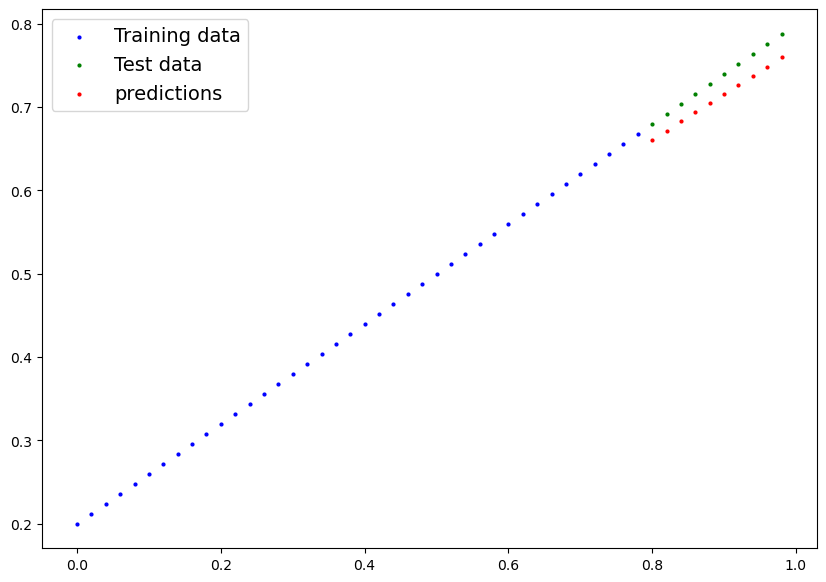

In [27]:
plot_predictions(predictions=y_preds)

### Saving the Model in PyTorch

In [28]:
# saving our pytorch model
from pathlib import Path

# 1. create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '02_PyTorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving the model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving the model to: models/02_PyTorch_workflow_model_0.pth


In [30]:
# check the saved file path
!ls -l models/02_PyTorch_workflow_model_0.pth

-rw-r--r-- 1 spadmin spadmin 1063 Nov 25 15:21 models/02_PyTorch_workflow_model_0.pth


### Loading a saved PyTorch model's `state_dict()`

In [31]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [33]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [34]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])